In [5]:
!pip install s3fs

In [2]:
# import scanpy as sc
# import s3fs
# import pandas as pd

# s3 = s3fs.S3FileSystem(anon=False)  # set anon=False if you need to use your AWS credentials

# # Use 's3.open' instead of the built-in 'open'
# with s3.open('s3://insitro-projects/ALS/ViViD/scseq/RNASEQ486.RNASEQ511.RNASEQ512.ready2use.noaggr.notether.filtered.actionet.h5ad', 'rb') as f:
#     adata = sc.read_h5ad(f)

In [9]:
import pandas as pd
import scipy.io
import s3fs
import gzip
import boto3
import gzip
from collections import Counter
from io import BytesIO
from io import StringIO
#from Bio import SeqIO
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
%config Completer.use_jedi = False

In [10]:
s3 = s3fs.S3FileSystem(anon=False)

# Path to the matrix file
matrix_path = 's3://insitro-sequencing-analysis/cellranger/230907_230906_INT176_Insitro_230825_Perturb_StdSC_i230825_Perturb/cellranger/SS107801/outs/filtered_feature_bc_matrix/matrix.mtx.gz'

# Path to the barcodes file
barcodes_path = 's3://insitro-sequencing-analysis/cellranger/230907_230906_INT176_Insitro_230825_Perturb_StdSC_i230825_Perturb/cellranger/SS107801/outs/filtered_feature_bc_matrix/barcodes.tsv.gz'

# Read the matrix file
with s3.open(matrix_path, 'rb') as f:
    with gzip.open(f, 'rb') as g:
        matrix = scipy.io.mmread(g)

# Read the barcodes file
with s3.open(barcodes_path, 'rb') as f:
    barcodes = pd.read_csv(f, sep='\t', compression='gzip', header=None)

print('Matrix:')
print(matrix)

print('\nBarcodes:')
print(barcodes.head())

Matrix:
  (67, 0)	1
  (72, 0)	1
  (100, 0)	1
  (111, 0)	2
  (115, 0)	1
  (127, 0)	1
  (129, 0)	1
  (137, 0)	1
  (139, 0)	2
  (148, 0)	1
  (156, 0)	1
  (159, 0)	3
  (161, 0)	1
  (162, 0)	1
  (167, 0)	1
  (182, 0)	1
  (204, 0)	1
  (229, 0)	2
  (247, 0)	2
  (250, 0)	1
  (254, 0)	2
  (274, 0)	2
  (284, 0)	1
  (291, 0)	1
  (306, 0)	2
  :	:
  (61679, 8495)	1
  (61921, 8495)	1
  (61948, 8495)	2
  (61954, 8495)	2
  (61957, 8495)	1
  (61971, 8495)	1
  (61985, 8495)	3
  (61992, 8495)	1
  (61996, 8495)	1
  (62302, 8495)	1
  (62313, 8495)	1
  (62323, 8495)	1
  (62667, 8495)	10
  (62669, 8495)	57
  (62671, 8495)	4
  (62675, 8495)	3
  (62681, 8495)	15
  (62684, 8495)	18
  (62687, 8495)	6
  (62688, 8495)	8
  (62693, 8495)	6
  (62697, 8495)	6
  (62698, 8495)	1
  (62700, 8495)	7
  (62724, 8495)	2

Barcodes:
                    0
0  AAACCCAAGCCTCTCT-1
1  AAACCCAAGCGCCTCA-1
2  AAACCCACATTCTCCG-1
3  AAACCCATCACTCTTA-1
4  AAACCCATCCACGTGG-1


In [25]:
#check to see if the barcodes that I have from MiSeq are within the CBC from 10X aggregated file
# S3 bucket names
bucket_barcodes = 'insitro-sequencing-analysis'
bucket_miseq = 'insitro-sequencing-archive'

# File paths
file_path_barcodes = 'cellranger/230906_INT176_Insitro_230825_Perturb_StdSC_VIVID.aggregated/outs/count/filtered_feature_bc_matrix/barcodes.tsv.gz'
file_paths_miseq = [ #here you can choose your FASTQs
    '231204_M06199_0347_000000000-LBC2F/fastqs/AACTAGCA_S1_L001_R1_001.fastq.gz',
    '231204_M06199_0347_000000000-LBC2F/fastqs/ATGGACTA_S4_L001_R1_001.fastq.gz',
    '231204_M06199_0347_000000000-LBC2F/fastqs/CAATGCTC_S3_L001_R1_001.fastq.gz',
    '231204_M06199_0347_000000000-LBC2F/fastqs/GACATCCG_S2_L001_R1_001.fastq.gz'
    ]

# sample ID's
AACTAGCA: ViViD-n=12_D10_DMSO_flow
ATGGACTA: ViViD-n=12_D10_bort_SOP
CAATGCTC: ViViD-n=12_D10_DMSO_SOP
GACATCCG: ViViD-n=12_D10_bort_flow






# Function to load data from S3
s3 = boto3.client('s3')
def load_data_from_s3(bucket, file_path):
    obj = s3.get_object(Bucket=bucket, Key=file_path)
    data = pd.read_csv(obj['Body'], sep='\t', compression='gzip')
    # Remove the "-1" from the end of each barcode
    data = data.iloc[:, 0].str.slice(0, -2) #slicing off the last two removes the "-1" from the end of the barcodes list
    return data

# Initialize an empty dictionary to store sequences for each Miseq run
sequences_dict = {}

# Load the Miseq data
for file_path_miseq in file_paths_miseq:
    obj = s3.get_object(Bucket=bucket_miseq, Key=file_path_miseq)

    # Assuming gzipped is your gzipped fastq data
    with gzip.GzipFile(fileobj=BytesIO(obj['Body'].read())) as f:
        sequences = []  # This will now be local to each loop iteration
        print_counter = 0  # Add a counter for printed statements
        total_lines = 0
        matching_lines = 0

        for i, line in enumerate(f):
            # Only consider sequence lines
            if i % 4 == 1: #only take the sequence values of the MiSeq output
                total_lines += 1
                # Decode the line from bytes to a unicode string
                decoded_line = line.decode('utf-8').strip()

                # Check the first 16 bases
                if decoded_line[:16] in barcodes_set:
                    sequences.append(decoded_line)
                    matching_lines += 1
                    if print_counter < 3:  # Only print the first 3 matches
                        print(f'Matching barcode in first 16 bases: {decoded_line[:16]}')
                        print_counter += 1

    # Store the sequences in the dictionary
    sequences_dict[file_path_miseq] = sequences

    print(f"Total lines checked in {file_path_miseq}: {total_lines}")
    print(f"Total matching lines in first 16 bases in {file_path_miseq}: {matching_lines}")
    if matching_lines == 0:
        print(f"No matching barcodes found in {file_path_miseq}")

Matching barcode in first 16 bases: TCTCCGAGTCGCACGT
Matching barcode in first 16 bases: ACGATGTGTTTGATCG
Matching barcode in first 16 bases: TTTCAGTGTTCCGGTG
Total lines checked in 231204_M06199_0347_000000000-LBC2F/fastqs/AACTAGCA_S1_L001_R1_001.fastq.gz: 3064225
Total matching lines in first 16 bases in 231204_M06199_0347_000000000-LBC2F/fastqs/AACTAGCA_S1_L001_R1_001.fastq.gz: 391
Matching barcode in first 16 bases: AATCGTGGTGGTCCCA
Matching barcode in first 16 bases: AGTGCCGCACTTCAAG
Matching barcode in first 16 bases: AATCGTGGTGGTCCCA
Total lines checked in 231204_M06199_0347_000000000-LBC2F/fastqs/ATGGACTA_S4_L001_R1_001.fastq.gz: 3101797
Total matching lines in first 16 bases in 231204_M06199_0347_000000000-LBC2F/fastqs/ATGGACTA_S4_L001_R1_001.fastq.gz: 556
Matching barcode in first 16 bases: AGCCAATGTCTTCAAG
Matching barcode in first 16 bases: GTTGTCCGTAACACCT
Matching barcode in first 16 bases: GTTGTCCGTAACACCT
Total lines checked in 231204_M06199_0347_000000000-LBC2F/fastqs/

In [14]:
#check to see if the barcodes that I have from MiSeq are within the CBC from 10X aggregated file
import boto3
s3 = boto3.Session().resource('s3')

# S3 bucket names
bucket_barcodes = 'insitro-sequencing-analysis'
bucket_miseq = 'insitro-sequencing-archive'
bucket = s3.Bucket(bucket_miseq)

# File paths
file_path_barcodes = 'cellranger/230906_INT176_Insitro_230825_Perturb_StdSC_VIVID.aggregated/outs/count/filtered_feature_bc_matrix/barcodes.tsv.gz'

# Define the prefix (folder path)
prefix = '231214_M06199_0353_000000000-LBRP4/fastq/'
# List all files in the bucket that start with the prefix and end with 'R1_001.fastq.gz'
file_paths_miseq = [obj.key for obj in bucket.objects.filter(Prefix=prefix) if obj.key.endswith('R1_001.fastq.gz')]

In [15]:
# Print all the file paths
for file_path in file_paths_miseq:
    print(file_path)

231214_M06199_0353_000000000-LBRP4/fastq/AAGGCAATTTAC_S10_L001_R1_001.fastq.gz
231214_M06199_0353_000000000-LBRP4/fastq/ACGTCAACTGCT_S4_L001_R1_001.fastq.gz
231214_M06199_0353_000000000-LBRP4/fastq/ATGACCTCTTCG_S2_L001_R1_001.fastq.gz
231214_M06199_0353_000000000-LBRP4/fastq/CCTGTCGCTATC_S7_L001_R1_001.fastq.gz
231214_M06199_0353_000000000-LBRP4/fastq/CGTAATTTTGTA_S5_L001_R1_001.fastq.gz
231214_M06199_0353_000000000-LBRP4/fastq/GCTATCCCCACG_S1_L001_R1_001.fastq.gz
231214_M06199_0353_000000000-LBRP4/fastq/GGACGCACCATT_S3_L001_R1_001.fastq.gz
231214_M06199_0353_000000000-LBRP4/fastq/GTTAATCCACCG_S11_L001_R1_001.fastq.gz
231214_M06199_0353_000000000-LBRP4/fastq/TCGGAAGCAAAC_S9_L001_R1_001.fastq.gz
231214_M06199_0353_000000000-LBRP4/fastq/TGCGCCTTACTC_S8_L001_R1_001.fastq.gz
231214_M06199_0353_000000000-LBRP4/fastq/TTAGCCCTCGAT_S6_L001_R1_001.fastq.gz
231214_M06199_0353_000000000-LBRP4/fastq/Undetermined_S0_L001_R1_001.fastq.gz


In [25]:
#check to see if the barcodes that I have from MiSeq are within the CBC from 10X aggregated file

# Function to load data from S3
s3 = boto3.client('s3')
def load_data_from_s3(bucket, file_path):
    obj = s3.get_object(Bucket=bucket, Key=file_path)
    data = pd.read_csv(obj['Body'], sep='\t', compression='gzip')
    # Remove the "-1" from the end of each barcode
    data = data.iloc[:, 0].str.slice(0, -2) #slicing off the last two removes the "-1" from the end of the barcodes list
    return data

# Initialize an empty dictionary to store sequences for each Miseq run
sequences_dict = {}

# Load the Miseq data
for file_path_miseq in file_paths_miseq:
    obj = s3.get_object(Bucket=bucket_miseq, Key=file_path_miseq)

    # Assuming gzipped is your gzipped fastq data
    with gzip.GzipFile(fileobj=BytesIO(obj['Body'].read())) as f:
        sequences = []  # This will now be local to each loop iteration
        print_counter = 0  # Add a counter for printed statements
        total_lines = 0
        matching_lines = 0

        for i, line in enumerate(f):
            # Only consider sequence lines
            if i % 4 == 1: #only take the sequence values of the MiSeq output
                total_lines += 1
                # Decode the line from bytes to a unicode string
                decoded_line = line.decode('utf-8').strip()

                # Check the first 16 bases
                if decoded_line[:16] in barcodes_set:
                    sequences.append(decoded_line)
                    matching_lines += 1
                    if print_counter < 3:  # Only print the first 3 matches
                        print(f'Matching barcode in first 16 bases: {decoded_line[:16]}')
                        print_counter += 1

    # Store the sequences in the dictionary
    sequences_dict[file_path_miseq] = sequences

    print(f"Total lines checked in {file_path_miseq}: {total_lines}")
    print(f"Total matching lines in first 16 bases in {file_path_miseq}: {matching_lines}")
    if matching_lines == 0:
        print(f"No matching barcodes found in {file_path_miseq}")

Matching barcode in first 16 bases: TCTCCGAGTCGCACGT
Matching barcode in first 16 bases: ACGATGTGTTTGATCG
Matching barcode in first 16 bases: TTTCAGTGTTCCGGTG
Total lines checked in 231204_M06199_0347_000000000-LBC2F/fastqs/AACTAGCA_S1_L001_R1_001.fastq.gz: 3064225
Total matching lines in first 16 bases in 231204_M06199_0347_000000000-LBC2F/fastqs/AACTAGCA_S1_L001_R1_001.fastq.gz: 391
Matching barcode in first 16 bases: AATCGTGGTGGTCCCA
Matching barcode in first 16 bases: AGTGCCGCACTTCAAG
Matching barcode in first 16 bases: AATCGTGGTGGTCCCA
Total lines checked in 231204_M06199_0347_000000000-LBC2F/fastqs/ATGGACTA_S4_L001_R1_001.fastq.gz: 3101797
Total matching lines in first 16 bases in 231204_M06199_0347_000000000-LBC2F/fastqs/ATGGACTA_S4_L001_R1_001.fastq.gz: 556
Matching barcode in first 16 bases: AGCCAATGTCTTCAAG
Matching barcode in first 16 bases: GTTGTCCGTAACACCT
Matching barcode in first 16 bases: GTTGTCCGTAACACCT
Total lines checked in 231204_M06199_0347_000000000-LBC2F/fastqs/

In [27]:
len(sequences_dict)

4

In [ ]:
df = pd.DataFrame(adata.X, columns=adata.var_names)
print(df.head())


In [11]:
print('\nBarcodes:')
print(barcodes.head(100))
print(len(barcodes))


Barcodes:
0     AAACCCAAGCGCCTCA
1     AAACCCACATTCTCCG
2     AAACCCATCACTCTTA
3     AAACCCATCCACGTGG
4     AAACCCATCGATTTCT
            ...       
95    AACAAGACAAATCAAG
96    AACAAGACAGTGTGGA
97    AACAAGACATTAAGCC
98    AACAAGAGTGAATGTA
99    AACAAGAGTGCACATT
Name: AAACCCAAGCCTCTCT-1, Length: 100, dtype: object
8495


In [ ]:
combined_barcodes = pd.concat([existing_barcodes, new_barcodes])

In [19]:
# import os
# import scanpy as sc
# import pandas as pd
# import s3fs

# s3 = s3fs.S3FileSystem(anon=False)

# # Paths to the matrix, barcodes, and genes files
# matrix_path = 'insitro-sequencing-analysis/cellranger/230907_230906_INT176_Insitro_230825_Perturb_StdSC_i230825_Perturb/cellranger/SS107801/outs/filtered_feature_bc_matrix/matrix.mtx.gz'
# barcodes_path = 'insitro-sequencing-analysis/cellranger/230907_230906_INT176_Insitro_230825_Perturb_StdSC_i230825_Perturb/cellranger/SS107801/outs/filtered_feature_bc_matrix/barcodes.tsv.gz'
# genes_path = 'insitro-sequencing-analysis/cellranger/230907_230906_INT176_Insitro_230825_Perturb_StdSC_i230825_Perturb/cellranger/SS107801/outs/filtered_feature_bc_matrix/features.tsv.gz'  # replace with your actual genes file path

# # Download the files
# s3.get(matrix_path, 'matrix.mtx.gz')
# s3.get(barcodes_path, 'barcodes.tsv.gz')
# s3.get(genes_path, 'features.tsv.gz')

# # Get the current directory
# current_dir = os.getcwd()

# # Read the data into an AnnData object
# adata = sc.read_10x_mtx(
#     current_dir,  # provide the directory, not the matrix file path
#     var_names='gene_symbols',
#     cache=True
# )

# # Read the barcodes file
# with open('barcodes.tsv.gz', 'rb') as f:
#     barcodes = pd.read_csv(f, sep='\t', compression='gzip', header=None)

# # Set the cell barcodes as the index of the AnnData object
# adata.obs.index = barcodes[0]

# print(adata)

# # Remove the downloaded files
# os.remove(os.path.join(current_dir, 'matrix.mtx.gz'))
# os.remove(os.path.join(current_dir, 'barcodes.tsv.gz'))
# os.remove(os.path.join(current_dir, 'features.tsv.gz'))

/root/miniconda3/envs/insitro/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/root/miniconda3/envs/insitro/lib/python3.9/site-packages/anndata/utils.py:260: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


AnnData object with n_obs × n_vars = 8496 × 62727
    var: 'gene_ids', 'feature_types'


In [24]:
# Sort the DataFrame by 'total_counts' in descending order
sorted_adata = adata.obs.sort_values(by='total_counts', ascending=False)

# Print the sorted DataFrame
print(sorted_adata)

                    total_counts
0                               
ACTGTCCGTAGAATAC-1       26758.0
CTCCACAAGACATAGT-1       23982.0
ATTTCTGTCGCCAGTG-1       23732.0
TACACCCCAAGACCGA-1       22562.0
CTACATTCATATCTCT-1       21470.0
...                          ...
AGACCATTCTGAATGC-1         503.0
GTTGTGAGTGTTGACT-1         501.0
GTCATTTGTGTCCTAA-1         500.0
ATTGGGTTCTGAGAGG-1         500.0
GCAACCGTCGGTCTGG-1         500.0

[8496 rows x 1 columns]


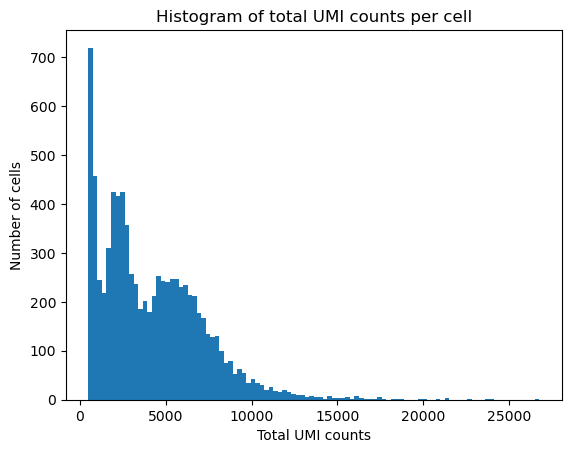

In [29]:
import matplotlib.pyplot as plt

# Plot a histogram of the total UMI counts
plt.hist(adata.obs['total_counts'], bins=100)
plt.xlabel('Total UMI counts')
plt.ylabel('Number of cells')
plt.title('Histogram of total UMI counts per cell')
plt.savefig('umi_histogram.png')

In [23]:
#print(adata.X[:5, :5].toarray())
print(adata.obs.head())  # print the first few cell barcodes
#print(adata.var.head())  # print the first few gene IDs and feature types


Empty DataFrame
Columns: []
Index: [AAACCCAAGCCTCTCT-1, AAACCCAAGCGCCTCA-1, AAACCCACATTCTCCG-1, AAACCCATCACTCTTA-1, AAACCCATCCACGTGG-1]
                    total_counts
0                               
AAACCCAAGCCTCTCT-1        8370.0
AAACCCAAGCGCCTCA-1        1296.0
AAACCCACATTCTCCG-1        2904.0
AAACCCATCACTCTTA-1        2063.0
AAACCCATCCACGTGG-1        1321.0
...                          ...
TTTGTTGGTACGACTT-1        2948.0
TTTGTTGGTGAATGAT-1        1929.0
TTTGTTGGTGCAATGG-1       11995.0
TTTGTTGTCATTGTGG-1        1754.0
TTTGTTGTCGGTGAAG-1        3411.0

[8496 rows x 1 columns]


In [ ]:
# Group by UMI and CBC, and count the number of occurrences
deduplicated = df.groupby(['UMI', 'CBC']).size().reset_index(name='counts')

# Now, each row in `deduplicated` represents a unique (UMI, CBC) pair

In [3]:
##
import Levenshtein as lv

In [ ]:
##Error Correction


def correct_errors(row):
    # For each UMI, find the most similar UMI that has a higher count
    similar = deduplicated[deduplicated['counts'] > row['counts']]
    similar['distance'] = similar['UMI'].apply(lambda x: lv.distance(x, row['UMI']))

    # If there's a UMI that's very similar (e.g., edit distance of 1), correct to that UMI
    if not similar.empty and similar['distance'].min() == 1:
        return similar.loc[similar['distance'].idxmin()]['UMI']
    else:
        return row['UMI']

# Apply the error correction function to each row
deduplicated['UMI_corrected'] = deduplicated.apply(correct_errors, axis=1)